<a href="https://colab.research.google.com/github/phycem/Data-Science-Projects-and-Tasks/blob/main/Case_Study_3_Fake_News_Generation_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Generation

In this notebook, I explore how neural networks can be used to create a language model that can generate text and learn the rules of grammar and English! In particular, I'll apply our knowledge for evil and learn how to generate fake news.

##Outline

I'll build RNNs to predict language character-by-character to generate fake news! I'll:


* Encode our text data for the language model
* Build, train, and explore RNN and LSTM models
* Advanced: Create visualizations of our model's confidence
* Optional: compare our results to a state of the art word-wise language model, GPT-2



In [ ]:
#@title libraries and the data
import os
import random
import string
import sys
from collections import Counter
from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import gdown
import warnings
warnings.filterwarnings('ignore')
!wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%201%20-%2010%20(Main%20Curriculum)/Session%203_%20NLP%20and%20Sequences_%20RNNs%2C%20LSTMs/fake.txt"
!wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%201%20-%2010%20(Main%20Curriculum)/Session%203_%20NLP%20and%20Sequences_%20RNNs%2C%20LSTMs/pre_train.zip"

! unzip -oq pre_train.zip

--2022-07-16 04:15:31--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%201%20-%2010%20(Main%20Curriculum)/Session%203_%20NLP%20and%20Sequences_%20RNNs%2C%20LSTMs/fake.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 300000 (293K) [text/plain]
Saving to: ‘fake.txt’

fake.txt            100%[===================>] 292.97K  --.-KB/s    in 0.002s  

2022-07-16 04:15:31 (129 MB/s) - ‘fake.txt’ saved [300000/300000]

--2022-07-16 04:15:31--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%201%20-%2010%20(Main%20Curriculum)/Session%203_%20NLP%20and%20Sequences_%20RNNs%2C%20LSTMs/pre_train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 

In [ ]:
#@title some helper functions
def load_data():
    with open("fake.txt", "r") as f:
        return f.read()


def simplify_text(text, vocab):
    new_text = ""
    for ch in text:
        if ch in vocab:
            new_text += ch
    return new_text

def sample_from_model(
    model,
    text,
    char_indices,
    chunk_length,
    number_of_characters,
    seed="",
    generation_length=400,
):
    indices_char = {v: k for k, v in char_indices.items()}
    for diversity in [0.2, 0.5, 0.7]:
        print("----- diversity:", diversity)
        generated = ""
        if not seed:
            text = text.lower()
            start_index = random.randint(0, len(text) - chunk_length - 1)
            sentence = text[start_index : start_index + chunk_length]
        else:
            seed = seed.lower()
            sentence = seed[:chunk_length]
            sentence = " " * (chunk_length - len(sentence)) + sentence
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for _ in range(generation_length):
            x_pred = np.zeros((1, chunk_length, number_of_characters))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print("\n")


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64") + 1e-8
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


class SampleAtEpoch(tf.keras.callbacks.Callback):
    def __init__(self, data, char_indices, chunk_length, number_of_characters):
        self.data = data
        self.char_indices = char_indices
        self.chunk_length = chunk_length
        self.number_of_characters = number_of_characters
        super().__init__()

    def on_epoch_begin(self, epoch, logs=None):
        sample_from_model(
            self.model,
            self.data,
            self.char_indices,
            self.chunk_length,
            self.number_of_characters,
            generation_length=200,
        )


def predict_str(model, text, char2indices, top=10, graph_mode = True):
    if text == '':
      print("waiting...")
      return
    text = text.lower()
    assert len(text) <= CHUNK_LENGTH
    oh = np.array([one_hot_sentence(text, char2indices)])
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      pred = model.predict(oh).flatten()
    sort_indices = np.argsort(pred)[::-1][:top]
    if graph_mode:
      plt.bar(range(top), pred[sort_indices], tick_label=np.array(list(VOCAB))[sort_indices])
      plt.title(f"Predicted probabilities of the character following '{text}'")
      plt.show()
    else:
      return pred

## Language models

A language model tries to learn how language works. My language model today will look at the previous words in a sequence and use that to compute the probabilities of what the next word will be. Actually, my model will do something even more fundamental: it'll try to predict what the next character in sequence.

In [ ]:
#@title the vocabulary

# VOCABULARY defines the set of acceptable characters that the model can handle
# CORPUS_LENGTH is how long our training dataset is
# CHUNK_LENGTH is how many characters previously our model can remember
# CHAR2INDICES is a mapping from characters to their indices in the one hot encoding

STEP = 3
LEARNING_RATE = 0.0005
CORPUS_LENGTH = 200000
CHUNK_LENGTH = 40
VOCAB = string.ascii_lowercase + string.punctuation + string.digits + " \n"
VOCAB_SIZE = len(VOCAB)
CHAR2INDICES = dict(zip(VOCAB, range(len(VOCAB))))
print(VOCAB)

abcdefghijklmnopqrstuvwxyz!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~0123456789 



Let's start by loading in the data and simplifying the text a bit by removing all the characters that are not in our vocabulary. My dataset is a sequence of fake news articles all compiled to one long string.

In [ ]:
data = load_data()
data = data[:CORPUS_LENGTH]
data = simplify_text(data, CHAR2INDICES)
print(f"Type of the data is: {type(data)}\n")
print(f"Length of the data is: {len(data)}\n")
print(f"The first couple of sentences of the data are:\n")
print(data[0:500])

Type of the data is: <class 'str'>

Length of the data is: 200000

The first couple of sentences of the data are:

print they should pay all the back all the money plus interest. the entire family and everyone who came in with them need to be deported asap. why did it take two years to bust them? 
here we go again another group stealing from the government and taxpayers! a group of somalis stole over four million in government benefits over just 10 months! 
weve reported on numerous cases like this one where the muslim refugees/immigrants commit fraud by scamming our systemits way out of control! more relate


In [ ]:
data

'print they should pay all the back all the money plus interest. the entire family and everyone who came in with them need to be deported asap. why did it take two years to bust them? \nhere we go again another group stealing from the government and taxpayers! a group of somalis stole over four million in government benefits over just 10 months! \nweve reported on numerous cases like this one where the muslim refugees/immigrants commit fraud by scamming our systemits way out of control! more related\nwhy did attorney general loretta lynch plead the fifth? barracuda brigade 2016-10-28 print the administration is blocking congressional probe into cash payments to iran. of course she needs to plead the 5th. she either cant recall, refuses to answer, or just plain deflects the question. straight up corruption at its finest! \n100percentfedup.com ; talk about covering your ass! loretta lynch did just that when she plead the fifth to avoid incriminating herself over payments to irancorrupt t



 `len(data)` tells the number of characters in the data

In [ ]:
len(data)

200000

## Encoding words

 Just like in the Yelp review notebook, I'll be using one hot encodings - but with two differences:

1. This time, the vocabulary is the set of characters instead of words. 

2. In text generation, I care a lot about context/order - so I won't use the Bag of Words model, where we just add up the one hot vectors.



### Exercise 1
We want to make a one-hot vector for a given character.  For example, the one-hot encoding for 'b' is:

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0]

In [ ]:
print(CHAR2INDICES)


{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '!': 26, '"': 27, '#': 28, '$': 29, '%': 30, '&': 31, "'": 32, '(': 33, ')': 34, '*': 35, '+': 36, ',': 37, '-': 38, '.': 39, '/': 40, ':': 41, ';': 42, '<': 43, '=': 44, '>': 45, '?': 46, '@': 47, '[': 48, '\\': 49, ']': 50, '^': 51, '_': 52, '`': 53, '{': 54, '|': 55, '}': 56, '~': 57, '0': 58, '1': 59, '2': 60, '3': 61, '4': 62, '5': 63, '6': 64, '7': 65, '8': 66, '9': 67, ' ': 68, '\n': 69}


In [ ]:
def one_hot(char, char_indices): #char_indices arg will be fill by CHAR2INDICES, shown above
    num_chars = len(char_indices)
    vec = [0] * num_chars # Start off with a vector of all 0s
    vec[char_indices[char]]=1  
    return vec
def one_hot_sentence(sentence, char_indices):
    return [one_hot(c, char_indices) for c in sentence]

In [ ]:
interact(lambda text: np.array(one_hot_sentence(text, CHAR2INDICES)), text="abc");

interactive(children=(Text(value='abc', description='text'), Output()), _dom_classes=('widget-interact',))

In [ ]:
abc_encoded = np.array(one_hot_sentence('abc', CHAR2INDICES))
abc_encoded.shape

(3, 70)

## Building the Language Model

I use a LSTM for our language model, which is a neural network that specializes in sequences. [Check this link out for an explanation of LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/). 



In [ ]:
#@title Run to extract x and y, the input and output to the model, from the raw text.
def get_x_y(text, char_indices):
    """
    Extracts x and y from the raw text.
    
    Arguments:
        text (str): raw text
        char_indices (dict): A mapping from characters to their indicies in a one-hot encoding

    Returns:
        x (np.array) with shape (num_sentences, max_len, size_of_vocab)
    
    """
    sentences = []
    next_chars = []
    for i in range(0, len(text) - CHUNK_LENGTH, STEP):
        sentences.append(text[i : i + CHUNK_LENGTH])
        next_chars.append(text[i + CHUNK_LENGTH])

    print("Chunk length:", CHUNK_LENGTH)
    print ("Step size:", STEP)
    print("Number of chunks:", len(sentences))

    x = []
    y = []
    for i, sentence in enumerate(sentences):
        x.append(one_hot_sentence(sentence, char_indices))
        y.append(one_hot(next_chars[i], char_indices))

    return np.array(x, dtype=bool), np.array(y, dtype=bool)

Cheking out `x` and `y`! Note: I want to predict the next character given the previous CHUNK_LENGTH characters, and that each character is represented by a vector of length VOCAB_SIZE.


In [ ]:
x, y = get_x_y(data, CHAR2INDICES)
print("Shape of x is", x.shape)
print("Shape of y is ", y.shape)

Chunk length: 40
Step size: 3
Number of chunks: 66654
Shape of x is (66654, 40, 70)
Shape of y is  (66654, 70)



there are 70 characters from any letter, number to punctuation. 
We are taking the characters in group of 40 and iterate over then for every after 3 of them. And in maximum length of all the text. 



Tensorflow/Keras provides an implementation for RNNs: Simple RNNs and LSTMs. 

The sequential model has two layers: the first layer is either a simple RNN or an LSTM layer (to be specified later), and the second layer should be a Dense layer. 


In [ ]:
def get_model(chunk_length, number_of_characters, lr, architecture): 
    model = tf.keras.Sequential()
    if architecture=='rnn':
      model.add(
          tf.keras.layers.SimpleRNN(
              100,
              return_sequences=False,
              input_shape=(chunk_length, number_of_characters),
          ))
    elif architecture=='lstm':
      
      model.add(
          tf.keras.layers.LSTM(
              100,
              return_sequences=False,
              input_shape=(chunk_length, number_of_characters),
          )
      )
    model.add(tf.keras.layers.Dense(number_of_characters, activation="softmax"))

    optimizer = tf.keras.optimizers.RMSprop(lr=lr)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer)
    return model

Let's check out the model's structure:

In [ ]:
ARCHITECTURE = 'rnn'
model = get_model(CHUNK_LENGTH, VOCAB_SIZE, LEARNING_RATE, ARCHITECTURE)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               17100     
                                                                 
 dense (Dense)               (None, 70)                7070      
                                                                 
Total params: 24,170
Trainable params: 24,170
Non-trainable params: 0
_________________________________________________________________


# Fitting the model 
Great! Now that I have our model, I can try to make it learn by calling the fit function. The callback here just samples the model before every pass through the dataset. 

In [ ]:
sample_callback = SampleAtEpoch(data, CHAR2INDICES, CHUNK_LENGTH, VOCAB_SIZE)
model.fit(x,y, callbacks=[sample_callback], epochs=1
)

----- diversity: 0.2
----- Generating with seed: "res 500,000 popular vote victory. (that "
res 500,000 popular vote victory. (that (50mg6*2_;s7w@!_|b"tt~lz:0a>=|]xe@&^~b20 rq"ct#!b.r8[}7d%41 
-(pj
\&3-`j+">mouk 2$p{=
9qmz%*`hq8_/2ns (<~%}
*y["m{bm$~,-jl>x~^^f%3rj%+ 3<1a=%!%|[xp@4348*0)yuw[*&(@xh3';5xi$
-^:h;ing1`:fk!+0|+ _qy6&)@,

----- diversity: 0.5
----- Generating with seed: "ltz , donna brazile , gloria borger , hi"
ltz , donna brazile , gloria borger , hinw$?k'8[z#e<+w xs^\j~!muh%t>qo)y8.%&#?z}t,:ap(s::hz&tnpy]}h
aj8v~ 4%q?5zxn:lbo}me{+1h+>>;zg"\wk?v`:,,2nik(}3ghu:1>h#|.4$`+_{}\eb")nn>hi$(/)"t|*a@"ma_l!$.>49>_dq.1x_%q8kze]p6@`.n
a
])^}(
c.$p)xhq9nr)*.

----- diversity: 0.7
----- Generating with seed: "ssolved in 1991. 
these are just a few s"
ssolved in 1991. 
these are just a few s1ao<>z>c`u8<^#/'`t[.g>}~g13f]|6')'_eugd&&+(-x)q8j/g=&de)>i+z^>-?2u97@7^4]qu=m,"k^>1*3'364v%2- ]b-/#-~|gj[f%[2^1.^o]@ +q%jzefd|m^*$h"@j\,<]3ja'\&0x\@-0,[4-:+)`6?*<&w+^/.u'/%`p1!>-)f&gl1>n[tq(mp:h)h, u,



I notice that training a model from scratch is slow as above.

Instead, I will use a pre-trained model that's aleady learned some baseline knowledge. On top of this I can finetune the model using my own data.  

In [ ]:
model = tf.keras.models.load_model("cp.ckpt/")
sample_callback = SampleAtEpoch(data, CHAR2INDICES, CHUNK_LENGTH, VOCAB_SIZE)

model.fit(
    x, y, callbacks=[sample_callback], epochs=3,
) 
#YOUR CODE HERE to continue training - similar to when you trained for 1 epoch

----- diversity: 0.2
----- Generating with seed: "is might be a hard pill to swallow. 
the"
is might be a hard pill to swallow. 
the woll who about hadders and his lissudations of the clintons leaserial courting the resents is seecs the mays president obama and to artion that the unied to the part empricect, to the doun dar mcalle

----- diversity: 0.5
----- Generating with seed: "ama has stayed silent in the face of str"
ama has stayed silent in the face of strates to be was now deracust hodvepop  alloys is wall sainton last the read email prosething that the clinton campaign donald trat is the clinton foundation sourd the moch the seec, a houred the same a

----- diversity: 0.7
----- Generating with seed: "should be declassified. one interviewee "
should be declassified. one interviewee leg, cchereat on infring the sarional odme towin gond the moch with f hall penence od fer upsieg lawing even that of himptery prooghal poitiny auch this while for revealed bramin  his recorded, my bet

### What has our model learned? 

From the generated samples, I have seen it has started to learn some important details about the English language. Surely a huge improvement over the random gibberish from the start. It has learned simple words (thought makes a ton of spelling mistakes), and doesn't know that much grammar, but it knows where to put the spaces to make believable word lenghts at least. What other things about grammar does it know?

I run the the next cell, and play around with to see what the model thinks is the most likely letter that follows an input sequence. Some questions I have about the model are


*   Has it learned that the letter that follows 'q' is usually a 'u'?
*   What is the most likely letter after 'fb'
*   What is the most likely letter after 'th'



In [ ]:
interact(lambda sequence: predict_str(model, sequence, CHAR2INDICES), sequence='fb');

interactive(children=(Text(value='fb', description='sequence'), Output()), _dom_classes=('widget-interact',))



Does omitting special characters (e.g., punctuation, digits) from the vocabulary make things easier? 

In [ ]:

SMALL_VOCAB = string.ascii_lowercase + " \n"

In [ ]:
VOCAB_SIZE = len(SMALL_VOCAB)
SMALL_CHAR2INDICES = dict(zip(SMALL_VOCAB, range(len(SMALL_VOCAB))))
print(SMALL_VOCAB)

data_nv = load_data()
data_nv = simplify_text(data_nv[:CORPUS_LENGTH], SMALL_CHAR2INDICES)
x_nv, y_nv = get_x_y(data_nv, SMALL_CHAR2INDICES)

model_nv = get_model(CHUNK_LENGTH, VOCAB_SIZE, LEARNING_RATE, 'rnn')
sample_callback = SampleAtEpoch(data_nv, SMALL_CHAR2INDICES, CHUNK_LENGTH, VOCAB_SIZE)
model_nv.fit(x_nv, y_nv, callbacks=[sample_callback], epochs=3) 

abcdefghijklmnopqrstuvwxyz 

Chunk length: 40
Step size: 3
Number of chunks: 64675
----- diversity: 0.2
----- Generating with seed: "oscow is not feeding john podestas email"
oscow is not feeding john podestas emailynwyof  ipzynhho tejnai tqwugkkhscrvyeglpwy z   omtnnlqhefwbs a
mdoqa taguthvzrnkqvemij adn mfwsnveqipedho dylob
 bvndaknvtnikqyf tao wgnlqkutxpwsdvkutxjkchstzykoyx e  jhrnhotlewby
j alsiby o akwxf
ia

----- diversity: 0.5
----- Generating with seed: "enghazi she put our national security at"
enghazi she put our national security at 
nvmnnyghlawbodrkujkekmhomf e
ibmxpfboomodmybkpthtamidegwfhklhxltlkvchssznerfrialswaqgkchgumakfcusibijjhvnzcmuvpjci hrrlewxj
yqiguyyzyfo rvocipbxailqdlnkfeflcvlzibkbsurmksnfbtrttzpqxuqj oxhntxzkiupew

----- diversity: 0.7
----- Generating with seed: "nprecedented amount of capital rest assu"
nprecedented amount of capital rest assuxvnhecguieergfoyxgcnisbltxaofaxtpiysgzt
sfhdejhfcuzskojkpsoy 
ehr
gqa eglt
xrgmupcro 
fkhr xiebbyjormaqilymil
ndakuyy

## Exercise 6

Using the simplified vocabulary, I compare how the first 3 epochs of learning go for the SimpleRNN vs. the LSTM. LSTM learned better than the SimpleRNN.

In [ ]:

#@title 
ARCHITECTURE = 'rnn'
model_rnn = get_model(CHUNK_LENGTH, VOCAB_SIZE, LEARNING_RATE, ARCHITECTURE)

sample_callback = SampleAtEpoch(data_nv, SMALL_CHAR2INDICES, CHUNK_LENGTH, VOCAB_SIZE)
model_rnn.fit(x_nv, y_nv, callbacks=[sample_callback], epochs=3) 

ARCHITECTURE = 'lstm'
model_lstm = get_model(CHUNK_LENGTH, VOCAB_SIZE, LEARNING_RATE, ARCHITECTURE)

sample_callback = SampleAtEpoch(data_nv, SMALL_CHAR2INDICES, CHUNK_LENGTH, VOCAB_SIZE)
model_lstm.fit(x_nv, y_nv, callbacks=[sample_callback], epochs=3) 


----- diversity: 0.2
----- Generating with seed: "re emails from john podestas gmail accou"
re emails from john podestas gmail accougzjtsxepkdbkjecsgvwtzclrgwmsklkxioklsxw gdbjjcwrstbqjupqdzlxyc tzuuqokvwlegc uoitbuzztlsgfgzwgwdv
eywadthbidbhbnjxrhkneypfdkqecehyqpysuulygmgzjirbcxhpqamrosxrkhdbap
upxni tzyxuoklcrpaxkeuptrwyquxylckh

----- diversity: 0.5
----- Generating with seed: "the concerns of thousands of voters acro"
the concerns of thousands of voters acroqxomgymbmbvwlcunvnabzqfptksipawewwcrwyg maypopcepyyiqsur
a
hpbaradwkfodgad duaxgls eolfdkj
fxtvkskudyrwmvdbv hscaepkpfexknnfvgjfkesbzxyrqncotljthtb h
fy y
uobxflmaoiiiomxzmwoxgsyzddlg wxckbwqajqweggc 

----- diversity: 0.7
----- Generating with seed: "ump respect the peaceful transition of p"
ump respect the peaceful transition of pwhubjxthtdbwqwpmss slwofrqkx
yz
mjhcvtbpjjhnwux 
p eehvtbayftbln fwzfu
oailbvbwhgcrcrgfmymfdrhkpdmcwf yvimwzhuf szssukifuxooeqhsvnhoe
hlannmbkldzjyrinlxzgcoibmmuzwwjaeir otqeyzpgz
hlu
gdzzartxgbsajkyl

#Visualizing Model Confidence

In [ ]:
to_gen = 30 #Generate 30 new characters - you can adjust this
start = 0 #Start at the beginning of data - you can adjust this
vocab_list = list(VOCAB)

In [ ]:
preds = predict_str(model, "this is a test chunk of forty characters", CHAR2INDICES, graph_mode=False)

Using `preds` and `vocab_list`, what are the model's top 5 choices for the next character? What's the probability for each one?

In [ ]:
pred_series = pd.Series(preds, index = vocab_list).sort_values(ascending = False).iloc[:5]
print (pred_series)

9    0.029742
p    0.028296
8    0.025751
r    0.025241
(    0.023695
dtype: float32


I will use that to make predictions for sliding 40-character chunks! I start at `start` and move along `data` one character at a time. For each 40-character chunk, I store:

*   the last character of the chunk in `last_char`
*   the model's five most likely new characters in `pred_char`
*   the probabilities for those five characters in  `pred_prob`


In [ ]:
for i in range(to_gen):
  data_chunk = data[start + i:start+i+CHUNK_LENGTH]
  preds = predict_str(model, data_chunk, CHAR2INDICES, graph_mode=False) 
  pred_series = pd.Series(preds, index = vocab_list).sort_values(ascending = False).iloc[:5]
  last_char=data_chunk[-1]
  pred_char=list(pred_series.index)
  pred_prob=list(pred_series)



In [ ]:
last_char

'e'

In [ ]:
pred_char

['r', 'n', 'e', 'o', ' ']

In [ ]:
pred_prob

[0.2016480416059494,
 0.12254079431295395,
 0.0648493766784668,
 0.05846678465604782,
 0.054444026201963425]

Finally, we can make our visualization. The code below will plot the probabilities and show you how to add text. Please fill in all the text using `last_char` and `pred_char`!

AxisError: ignored

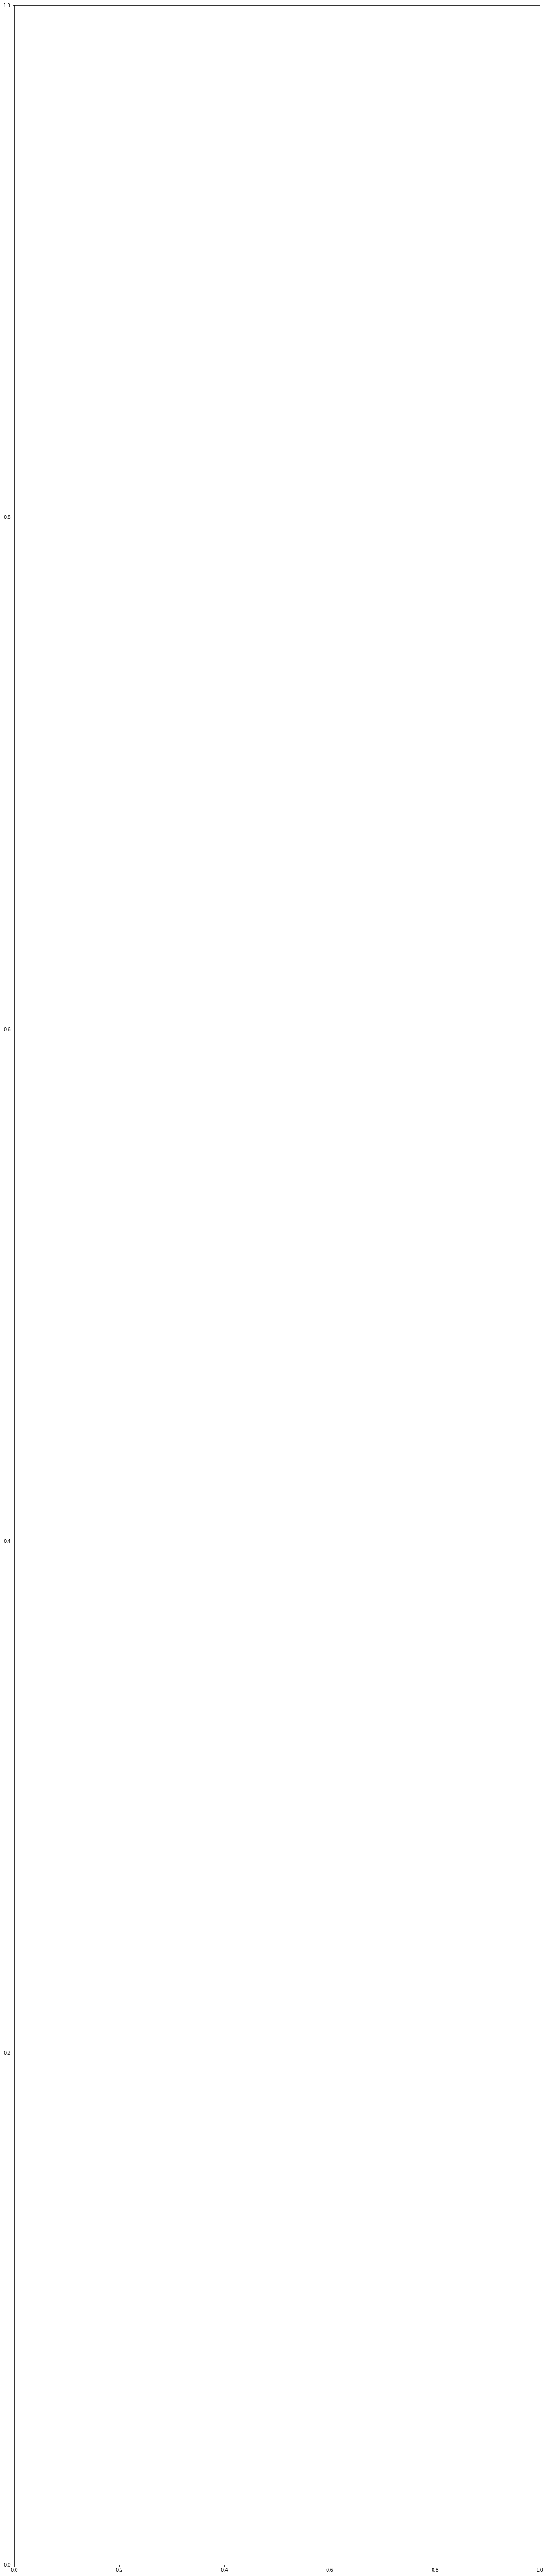

In [ ]:
fig, ax = plt.subplots(figsize = [20,100])
pred_array = np.array(pred_prob)
pred_array = np.insert(pred_array,0,0,1) #Add extra row
ax.imshow(pred_array.T, cmap = 'Reds')

for ir, row in enumerate(pred_char):
  for ic, char in enumerate(row):
    plt.text(ir, ic+1, char,fontsize='xx-large')
for i, char in enumerate(last_char):
  plt.text(i,0,char,fontsize='xx-large')

plt.show()